# tfp-multiple-changepoint-detection

Author: Henry Cooksley

Adapted from [Multiple changepoint detection and Bayesian model selection](https://www.tensorflow.org/probability/examples/Multiple_changepoint_detection_and_Bayesian_model_selection)

In [1]:
# Install requirements as needed
# !pip install -r requirements.txt

### Imports

In [2]:
import numpy as np
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

from matplotlib import pylab as plt
%matplotlib inline
import scipy.stats

### Task: changepoint detection with multiple changepoints

In [3]:
# true_rates = [40, 3, 20, 50]
# true_durations = [10, 20, 5, 35]
true_rates = [50, 3, 20, 50]
true_durations = [35, 20, 5, 35]
observed_counts = np.concatenate([
    scipy.stats.poisson(rate).rvs(num_steps) 
        for (rate, num_steps) in zip(true_rates, true_durations)
]).astype(np.float32)
observed_counts

array([50., 57., 53., 63., 59., 58., 51., 51., 43., 49., 42., 52., 43.,
       52., 39., 41., 49., 47., 48., 57., 44., 42., 53., 48., 40., 28.,
       46., 45., 48., 61., 50., 50., 40., 47., 41.,  5.,  2.,  4.,  4.,
        5.,  2.,  1.,  3.,  2.,  4.,  1.,  4.,  0.,  7.,  6.,  7.,  5.,
        0.,  4.,  4., 18., 13., 16., 17., 21., 44., 57., 56., 62., 56.,
       55., 47., 56., 42., 45., 48., 50., 49., 44., 50., 52., 47., 61.,
       49., 50., 50., 39., 50., 41., 59., 54., 53., 56., 50., 53., 44.,
       49., 66., 37., 53.], dtype=float32)

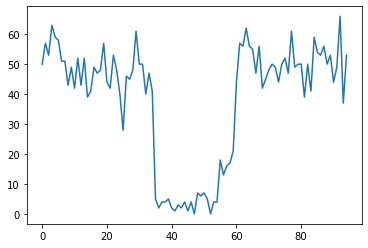

In [4]:
plt.plot(observed_counts);

### Known number of states

In [5]:
num_states = 4
# num_states = 2
initial_state_logits = np.zeros([num_states], dtype=np.float32)
initial_state_logits

array([0., 0., 0., 0.], dtype=float32)

In [6]:
daily_change_prob = 0.05
transition_probs = daily_change_prob / (num_states-1) * np.ones(
    [num_states, num_states], dtype=np.float32)
transition_probs

array([[0.01666667, 0.01666667, 0.01666667, 0.01666667],
       [0.01666667, 0.01666667, 0.01666667, 0.01666667],
       [0.01666667, 0.01666667, 0.01666667, 0.01666667],
       [0.01666667, 0.01666667, 0.01666667, 0.01666667]], dtype=float32)

In [7]:
np.fill_diagonal(transition_probs, 
                 1-daily_change_prob)

In [8]:
print(f"Initial state logits:\n{initial_state_logits}")
print(f"Transition matrix:\n{transition_probs}")

Initial state logits:
[0. 0. 0. 0.]
Transition matrix:
[[0.95       0.01666667 0.01666667 0.01666667]
 [0.01666667 0.95       0.01666667 0.01666667]
 [0.01666667 0.01666667 0.95       0.01666667]
 [0.01666667 0.01666667 0.01666667 0.95      ]]


In [9]:
trainable_log_rates = tf.Variable(
    np.log(np.mean(observed_counts)) + tf.random.normal([num_states]),
    name='log_rates')
trainable_log_rates

<tf.Variable 'log_rates:0' shape=(4,) dtype=float32, numpy=array([4.545434 , 3.8742478, 3.0030103, 2.6731877], dtype=float32)>

In [10]:
hmm = tfd.HiddenMarkovModel(
    initial_distribution=tfd.Categorical(
        logits=initial_state_logits),
    transition_distribution=tfd.Categorical(probs=transition_probs),
    observation_distribution=tfd.Poisson(log_rate=trainable_log_rates),
    num_steps=len(observed_counts))
hmm

<tfp.distributions.HiddenMarkovModel 'HiddenMarkovModel' batch_shape=[] event_shape=[95] dtype=float32>

In [11]:
rate_prior = tfd.LogNormal(5, 5)
rate_prior

<tfp.distributions.LogNormal 'LogNormal' batch_shape=[] event_shape=[] dtype=float32>

In [12]:
def log_prob():
    return (tf.reduce_sum(rate_prior.log_prob(tf.math.exp(trainable_log_rates))) +
           hmm.log_prob(observed_counts))

In [13]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)
optimizer

In [14]:
@tf.function(autograph=False)
def train_op():
    with tf.GradientTape() as tape:
        neg_log_prob = -log_prob()
    grads = tape.gradient(neg_log_prob, [trainable_log_rates])[0]
    optimizer.apply_gradients([(grads, trainable_log_rates)])
    return neg_log_prob, tf.math.exp(trainable_log_rates)


In [15]:
for step in range(201):
    loss, rates = [t.numpy() for t in train_op()]
    if step % 20 == 0:
        print(f"step {step}: log prob {-loss} rates {rates}")
        print("\n")

print("\n")
print(f"Inferred rates: {rates}")
print("\n")
print(f"True rates: {true_rates}")

step 0: log prob -451.5906066894531 rates [85.23687  53.21007  18.22894  13.107542]


step 20: log prob -329.1844482421875 rates [44.896515  50.392735  17.04615    3.0479593]


step 40: log prob -329.4576721191406 rates [46.783775 51.29979  16.807705  2.881233]


step 60: log prob -328.21282958984375 rates [46.793056  51.22007   16.811556   3.6117597]


step 80: log prob -328.1457824707031 rates [46.61714   51.160538  16.83089    3.4724982]


step 100: log prob -328.1460876464844 rates [46.609528  51.15156   16.814703   3.4334073]


step 120: log prob -328.1439208984375 rates [46.660706  51.1579    16.81985    3.4680932]


step 140: log prob -328.14349365234375 rates [46.64212  51.154537 16.819595  3.454104]


step 160: log prob -328.1436462402344 rates [46.648384  51.156048  16.81921    3.4583833]


step 180: log prob -328.143310546875 rates [46.64708   51.155804  16.819038   3.4572554]


step 200: log prob -328.1434326171875 rates [46.646748  51.15561   16.819098   3.4575305]




Inf

#### Recovering the state trajectory

In [16]:
posterior_dists = hmm.posterior_marginals(observed_counts)
posterior_dists

<tfp.distributions.Categorical 'HiddenMarkovModel_posterior_marginals_Categorical' batch_shape=[95] event_shape=[] dtype=int32>

In [17]:
posterior_probs = posterior_dists.probs_parameter().numpy()
posterior_probs

array([[1.0167861e-01, 8.9832139e-01, 9.9782240e-12, 0.0000000e+00],
       [8.9216262e-02, 9.1078377e-01, 1.5064817e-16, 0.0000000e+00],
       [8.5809775e-02, 9.1419023e-01, 1.0447875e-14, 0.0000000e+00],
       [8.5726015e-02, 9.1427398e-01, 2.2456555e-19, 0.0000000e+00],
       [1.0156995e-01, 8.9843005e-01, 2.8649669e-17, 0.0000000e+00],
       [1.4457481e-01, 8.5542518e-01, 1.6306469e-16, 0.0000000e+00],
       [2.4538440e-01, 7.5461560e-01, 4.5353044e-13, 0.0000000e+00],
       [3.6800814e-01, 6.3199186e-01, 5.4009802e-13, 0.0000000e+00],
       [5.1736516e-01, 4.8263487e-01, 2.3692390e-09, 4.3139794e-33],
       [6.0372746e-01, 3.9627260e-01, 3.1512906e-12, 0.0000000e+00],
       [6.9130856e-01, 3.0869147e-01, 4.2267700e-09, 3.7438528e-32],
       [7.3696297e-01, 2.6303700e-01, 9.0125024e-14, 0.0000000e+00],
       [7.9900652e-01, 2.0099351e-01, 1.1472507e-09, 2.0889477e-33],
       [8.3452070e-01, 1.6547929e-01, 7.6338207e-14, 0.0000000e+00],
       [8.8309735e-01, 1.1690255e-

In [18]:
def plot_state_posterior(ax, state_posterior_probs, title):
    ln1 = ax.plot(state_posterior_probs, c='blue', lw=3, label='p(state | counts)')
    ax.set_ylim(0., 1.1)
    ax.set_ylabel('posterior probability')
    ax2 = ax.twinx()
    ln2 = ax2.plot(observed_counts, c='black', alpha=0.3, label='observed counts')
    ax2.set_title(title)
    ax2.set_xlabel('time')
    lns = ln1+ln2
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc=4)
    ax.grid(True, color='white')
    ax2.grid(False)


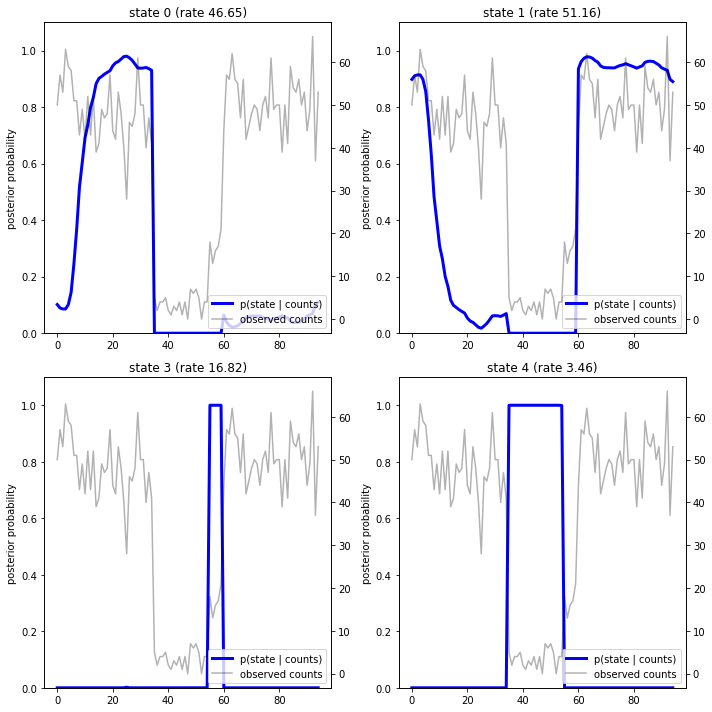

In [19]:
fig = plt.figure(figsize=(10, 10))
nrows_ncols = (2, 2)
plot_state_posterior(fig.add_subplot(*nrows_ncols, 1),
                    posterior_probs[:, 0],
                    title=f"state 0 (rate {rates[0]:.2f})")
plot_state_posterior(fig.add_subplot(*nrows_ncols, 2),
                    posterior_probs[:, 1],
                    title=f"state 1 (rate {rates[1]:.2f})")
if num_states == 4:
    plot_state_posterior(fig.add_subplot(*nrows_ncols, 3),
                        posterior_probs[:, 2],
                        title=f"state 3 (rate {rates[2]:.2f})")
    plot_state_posterior(fig.add_subplot(*nrows_ncols, 4),
                        posterior_probs[:, 3],
                        title=f"state 4 (rate {rates[3]:.2f})")
plt.tight_layout()

In [20]:
most_probable_states = np.argmax(posterior_probs, axis=1)
most_probable_states

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1])

In [21]:
most_probable_rates = rates[most_probable_states]
most_probable_rates

array([51.15561  , 51.15561  , 51.15561  , 51.15561  , 51.15561  ,
       51.15561  , 51.15561  , 51.15561  , 46.646748 , 46.646748 ,
       46.646748 , 46.646748 , 46.646748 , 46.646748 , 46.646748 ,
       46.646748 , 46.646748 , 46.646748 , 46.646748 , 46.646748 ,
       46.646748 , 46.646748 , 46.646748 , 46.646748 , 46.646748 ,
       46.646748 , 46.646748 , 46.646748 , 46.646748 , 46.646748 ,
       46.646748 , 46.646748 , 46.646748 , 46.646748 , 46.646748 ,
        3.4575305,  3.4575305,  3.4575305,  3.4575305,  3.4575305,
        3.4575305,  3.4575305,  3.4575305,  3.4575305,  3.4575305,
        3.4575305,  3.4575305,  3.4575305,  3.4575305,  3.4575305,
        3.4575305,  3.4575305,  3.4575305,  3.4575305,  3.4575305,
       16.819098 , 16.819098 , 16.819098 , 16.819098 , 16.819098 ,
       51.15561  , 51.15561  , 51.15561  , 51.15561  , 51.15561  ,
       51.15561  , 51.15561  , 51.15561  , 51.15561  , 51.15561  ,
       51.15561  , 51.15561  , 51.15561  , 51.15561  , 51.1556

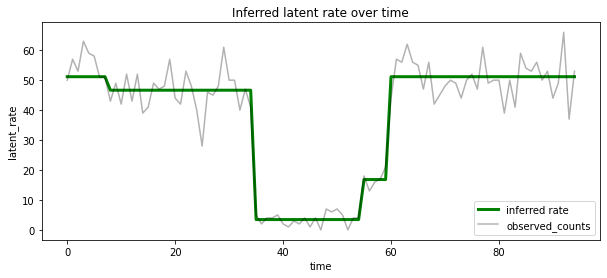

In [22]:
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1, 1, 1)
ax.plot(most_probable_rates, c='green', lw=3, label='inferred rate')
ax.plot(observed_counts, c='black', alpha=0.3, label='observed_counts')
ax.set_ylabel('latent_rate')
ax.set_xlabel('time')
ax.set_title('Inferred latent rate over time')
ax.legend(loc=4);

### Unknown number of states

In [23]:
max_num_states = 10

def build_latent_state(num_states, max_num_states, daily_change_prob=0.05):
    
    # Give probability exp(-100) ~= 0 to states outside of the current model.
    initial_state_logits = -100. * np.ones([max_num_states], dtype=np.float32)
    initial_state_logits[:num_states] = 0.
    
    # Build a transition matrix that transitions only within the current `num_states` states.
    transition_probs = np.eye(max_num_states, dtype=np.float32)
    if num_states > 1:
        transition_probs[:num_states, :num_states] = (
            daily_change_prob / (num_states-1))
        np.fill_diagonal(transition_probs[:num_states, :num_states],
                        1-daily_change_prob)
    return initial_state_logits, transition_probs    

In [24]:
# For each candidate model, build the initial state prior and transition matrix.
batch_initial_state_logits = []
batch_transition_probs = []
for num_states in range(1, max_num_states+1):
    initial_state_logits, transition_probs = build_latent_state(
        num_states=num_states,
        max_num_states=max_num_states)
    batch_initial_state_logits.append(initial_state_logits)
    batch_transition_probs.append(transition_probs)

batch_initial_state_logits = np.array(batch_initial_state_logits)
batch_initial_state_logits

array([[   0., -100., -100., -100., -100., -100., -100., -100., -100.,
        -100.],
       [   0.,    0., -100., -100., -100., -100., -100., -100., -100.,
        -100.],
       [   0.,    0.,    0., -100., -100., -100., -100., -100., -100.,
        -100.],
       [   0.,    0.,    0.,    0., -100., -100., -100., -100., -100.,
        -100.],
       [   0.,    0.,    0.,    0.,    0., -100., -100., -100., -100.,
        -100.],
       [   0.,    0.,    0.,    0.,    0.,    0., -100., -100., -100.,
        -100.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0., -100., -100.,
        -100.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0., -100.,
        -100.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        -100.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.]], dtype=float32)

In [25]:
batch_transition_probs = np.array(batch_transition_probs)
batch_transition_probs

array([[[1.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 1.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 1.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 1.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 1.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         1.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 1.        , 0.        , 0.        , 0.        ],
        [0.        , 0.    

In [26]:
print(f"Shape of initial_state_logits: {batch_initial_state_logits.shape}")

Shape of initial_state_logits: (10, 10)


In [27]:
print(f"Shape of transition probs: {batch_transition_probs.shape}")

Shape of transition probs: (10, 10, 10)


In [28]:
print(f"Example initial state logits for num_states==3:\n{batch_initial_state_logits[2, :]}")


Example initial state logits for num_states==3:
[   0.    0.    0. -100. -100. -100. -100. -100. -100. -100.]


In [29]:
print(f"Example transition_probs for num_states==3:\n{batch_transition_probs[2, :, :]}")

Example transition_probs for num_states==3:
[[0.95  0.025 0.025 0.    0.    0.    0.    0.    0.    0.   ]
 [0.025 0.95  0.025 0.    0.    0.    0.    0.    0.    0.   ]
 [0.025 0.025 0.95  0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    1.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    1.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    1.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    1.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    1.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    1.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    1.   ]]


In [30]:
trainable_log_rates = tf.Variable(
    (np.log(np.mean(observed_counts)) *
    np.ones([batch_initial_state_logits.shape[0], max_num_states]) +
    tf.random.normal([1, max_num_states])),
    name='log_rates')
trainable_log_rates

<tf.Variable 'log_rates:0' shape=(10, 10) dtype=float32, numpy=
array([[1.8655145, 4.7376037, 2.7600322, 4.298501 , 3.0585198, 4.760975 ,
        3.6428678, 2.28244  , 4.1279635, 1.9910526],
       [1.8655145, 4.7376037, 2.7600322, 4.298501 , 3.0585198, 4.760975 ,
        3.6428678, 2.28244  , 4.1279635, 1.9910526],
       [1.8655145, 4.7376037, 2.7600322, 4.298501 , 3.0585198, 4.760975 ,
        3.6428678, 2.28244  , 4.1279635, 1.9910526],
       [1.8655145, 4.7376037, 2.7600322, 4.298501 , 3.0585198, 4.760975 ,
        3.6428678, 2.28244  , 4.1279635, 1.9910526],
       [1.8655145, 4.7376037, 2.7600322, 4.298501 , 3.0585198, 4.760975 ,
        3.6428678, 2.28244  , 4.1279635, 1.9910526],
       [1.8655145, 4.7376037, 2.7600322, 4.298501 , 3.0585198, 4.760975 ,
        3.6428678, 2.28244  , 4.1279635, 1.9910526],
       [1.8655145, 4.7376037, 2.7600322, 4.298501 , 3.0585198, 4.760975 ,
        3.6428678, 2.28244  , 4.1279635, 1.9910526],
       [1.8655145, 4.7376037, 2.7600322, 4.2985

In [31]:
hmm = tfd.HiddenMarkovModel(
    initial_distribution=tfd.Categorical(
        logits=batch_initial_state_logits),
    transition_distribution=tfd.Categorical(probs=batch_transition_probs),
    observation_distribution=tfd.Poisson(log_rate=trainable_log_rates),
    num_steps=len(observed_counts))
hmm

<tfp.distributions.HiddenMarkovModel 'HiddenMarkovModel' batch_shape=[10] event_shape=[95] dtype=float32>

In [32]:
rate_prior = tfd.LogNormal(5, 5)
rate_prior

<tfp.distributions.LogNormal 'LogNormal' batch_shape=[] event_shape=[] dtype=float32>

In [33]:
def log_prob():
    prior_lps = rate_prior.log_prob(tf.math.exp(trainable_log_rates))
    prior_lp = tf.stack(
        [tf.reduce_sum(prior_lps[i, :i+1]) for i in range(max_num_states)])
    return prior_lp + hmm.log_prob(observed_counts)

In [34]:
@tf.function(autograph=False)
def train_op():
    with tf.GradientTape() as tape:
        neg_log_prob = -log_prob()
    grads = tape.gradient(neg_log_prob, [trainable_log_rates])[0]
    optimizer.apply_gradients([(grads, trainable_log_rates)])
    return neg_log_prob, tf.math.exp(trainable_log_rates)

In [35]:
for step in range(201):
    loss, rates = [t.numpy() for t in train_op()]
    if step % 20 == 0:
        print(f"step {step}:")
        print(f"loss {loss}")
        print("\n")

step 0:
loss [1064.8617  1072.8223  1078.6165   656.6727   657.97327  666.6433
  468.42325  474.45358  443.0875   448.5831 ]


step 20:
loss [1064.3811   395.45117  361.66107  331.69833  338.34552  346.08682
  351.92966  354.4171   360.97678  362.76068]


step 40:
loss [1058.5333   358.08936  323.71884  330.46588  337.16928  343.99734
  349.1601   352.4823   357.4502   358.49832]


step 60:
loss [1056.901    357.94128  323.8348   330.0389   336.93768  343.42807
  348.61755  351.6547   355.87274  356.1679 ]


step 80:
loss [1056.1681   357.29993  323.42667  329.926    336.84665  342.469
  348.5089   351.26605  354.71216  354.63452]


step 100:
loss [1055.759    357.19385  323.30417  329.91324  336.75494  341.7265
  348.45462  350.98114  354.28586  353.44427]


step 120:
loss [1055.5337   357.19565  323.30438  329.90842  336.641    341.52756
  348.40375  350.69968  353.8488   352.46475]


step 140:
loss [1055.4115   357.1941   323.30273  329.90277  336.22955  341.47095
  348.35184  350.4

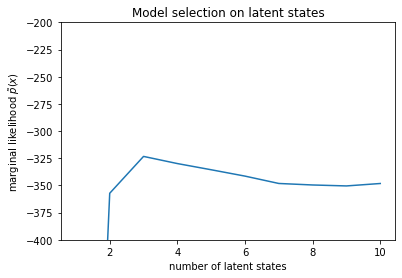

In [36]:
num_states = np.arange(1, max_num_states+1)
plt.plot(num_states, -loss)
plt.ylim([-400, -200])
plt.ylabel("marginal likelihood $\\tilde{p}(x)$")
plt.xlabel("number of latent states")
plt.title("Model selection on latent states");

In [37]:
for i, learned_model_rates in enumerate(rates):
  print("rates for {}-state model: {}".format(i+1, learned_model_rates[:i+1]))

rates for 1-state model: [5.0668723e-09]
rates for 2-state model: [ 5.619364 49.073402]
rates for 3-state model: [ 3.457492 49.432297 16.832537]
rates for 4-state model: [ 3.4566805 49.43047   16.825455  11.314769 ]
rates for 5-state model: [ 3.456284 16.509804 16.645588 10.187881 49.43021 ]
rates for 6-state model: [ 3.4566267 16.459892  16.456142  10.146839  49.430164  16.445843 ]
rates for 7-state model: [ 3.45748  51.02008  16.635056 51.019848 16.635023 46.444874 98.365845]
rates for 8-state model: [3.2981884e-02 5.1005241e+01 1.6634436e+01 5.1004608e+01 1.6634390e+01
 4.6469429e+01 9.9555916e+01 3.4581079e+00]
rates for 9-state model: [3.2933153e-02 5.1113804e+01 1.6633839e+01 5.0913513e+01 1.6633894e+01
 3.3794408e+00 4.6493233e+01 3.3794887e+00 4.4505949e+00]
rates for 10-state model: [3.1598162e-02 5.1062416e+01 1.6451101e+01 1.6451506e+01 1.6452093e+01
 5.0950245e+01 4.6511627e+01 3.4324579e+00 4.7200999e+00 7.8120813e-08]


In [38]:
posterior_probs = hmm.posterior_marginals(
    observed_counts).probs_parameter().numpy()
posterior_probs

array([[[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        ...,
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],

       [[3.4289234e-30, 1.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [4.6588138e-38, 1.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [2.7096419e-34, 1.0000000e+00, 0.0000000e+00, ...,
         0.000

In [39]:
most_probable_states = np.argmax(posterior_probs, axis=-1)
most_probable_states

array([[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1,

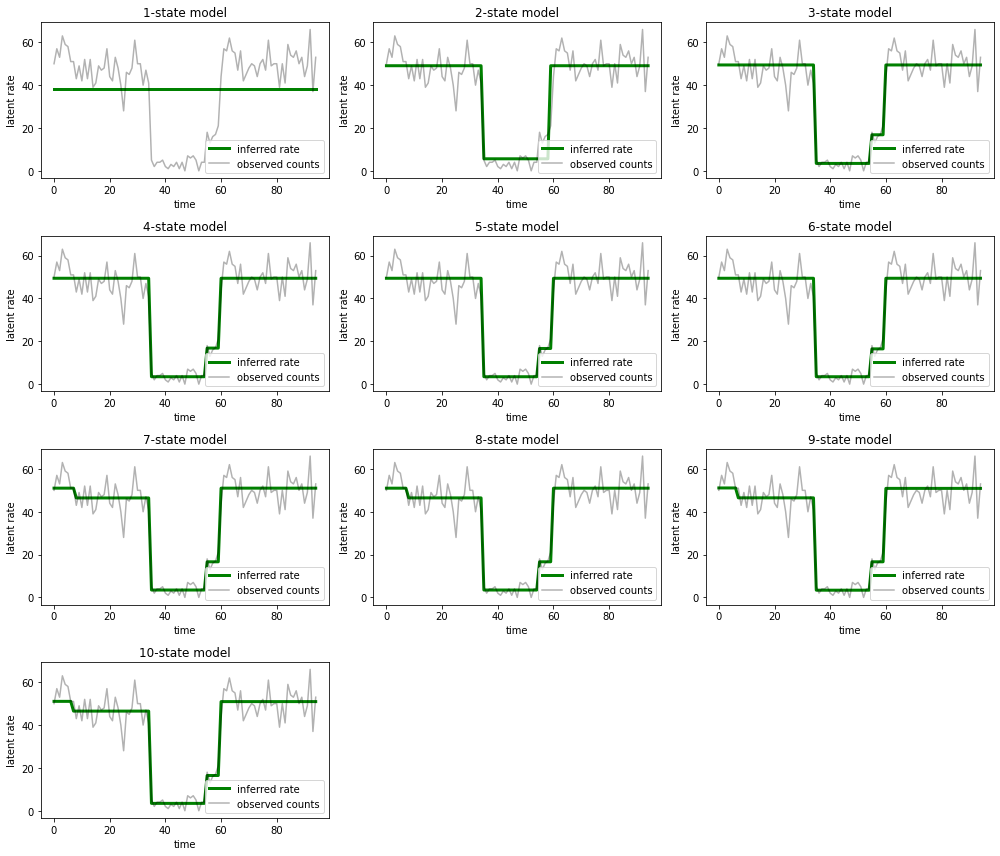

In [40]:
fig = plt.figure(figsize=(14, 12))
for i, learned_model_rates in enumerate(rates):
  ax = fig.add_subplot(4, 3, i+1)
  ax.plot(learned_model_rates[most_probable_states[i]], c='green', lw=3, label='inferred rate')
  ax.plot(observed_counts, c='black', alpha=0.3, label='observed counts')
  ax.set_ylabel("latent rate")
  ax.set_xlabel("time")
  ax.set_title("{}-state model".format(i+1))
  ax.legend(loc=4)
plt.tight_layout()